In [1]:
import pandas as pd
import numpy as np
from operator import add
import matplotlib.pyplot as plt
import itertools
from code.forecast import PI_combinations
from code.evaluation import get_PI_from_distribution, get_PI_percentiles
from code.evaluation import get_coverage_indicators, Christoffersen_scores
from code.evaluation import plot_coverage, calculate_UC_LR_score
from code.evaluation import winkler_score, DM_test

idx = pd.IndexSlice

In [2]:
preprocess = lambda df: df.set_index( 
    # merge date and time to get datetime and set index
    pd.to_datetime(
        df['Date'] + " " + df['Hour'],
        dayfirst=True
    )
) \
.drop(columns=['Date', 'Hour']) \
.apply(
    # remove decimal seperator ","
    lambda col: col.astype(str).str.replace(',','').astype(float)
) \
.tz_localize('Europe/Istanbul') # add timezone info

get_hourly_df = lambda df, column: df.groupby(df.index.hour)[column].apply(
    lambda col: col.to_dict()).to_frame().dropna()

In [3]:
price_df = pd.read_parquet('./data/Price_df_processed.parquet')
load_df_raw = pd.read_csv('data/LoadForecast-01042018-28032021.csv')
load_df = preprocess(load_df_raw).rename(columns={'Load Forecast (MWh)':'Load_Forecast_MWh'})

In [4]:
model_names = [
    'ARX_1_2_7','ARX_to_7', 'ARX_to_7_w_lasso_aic',
    'TARX_1_2_7','TARX_to_7', 'TARX_to_7_w_lasso_aic',
    'mARX_1_2_7','mARX_to_7', 'mARX_to_7_w_lasso_aic',
]

d_path = './data/Distributional_forecasts'
for model in model_names:
    file_name = f"{model}_distributional.parquet"
    globals()[model + '_dist_df'] = pd.read_parquet(f'{d_path}/{file_name}')

naive_forecast_df = pd.read_parquet('./data/Benchmark_forecasts/Naive_forecast_df.parquet')
auto_ar_forecast_df = pd.read_parquet('./data/Benchmark_forecasts/AutoAr_forecast_df.parquet')
PI_QRA = pd.read_parquet('./data/QRA_forecasts/qra_forecast_df_general.parquet')
PI_QRA_1_2_7 = pd.read_parquet('./data/QRA_forecasts/qra_forecast_df_1_2_7.parquet')
PI_QRA_to_7 = pd.read_parquet('./data/QRA_forecasts/qra_forecast_df_to_7.parquet')
PI_QRA_to_7_w_lasso = pd.read_parquet('./data/QRA_forecasts/qra_forecast_df_to_7_w_lasso.parquet')

In [5]:
for model in model_names:
    globals()["PI_"+model] = get_PI_percentiles(eval(model + '_dist_df'))
    
PI_Naive = get_PI_from_distribution(naive_forecast_df.PI_historical)
PI_AutoAR = get_PI_from_distribution(auto_ar_forecast_df.PI_historical)

In [6]:
figsize = (12,4)

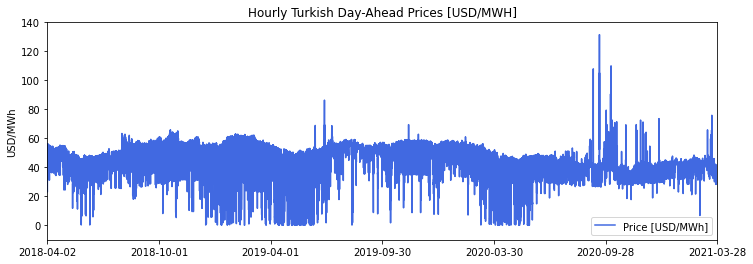

In [7]:
fig, ax = plt.subplots(figsize=figsize)
plt.plot(price_df.loc['2018-04-02':], color='royalblue', label='Price [USD/MWh]')
plt.ylabel("USD/MWh")
plt.title("Hourly Turkish Day-Ahead Prices [USD/MWH]")
plt.xlim(pd.Timestamp('2018-04-02'), pd.Timestamp('2021-03-28'))
plt.ylim(-10, 140)
plt.xticks(list(pd.date_range('2018-04-02', '2021-03-28', freq='W-MON')[::26]) + [pd.Timestamp('2021-03-28')])
plt.legend(loc='lower right')
plt.savefig('./plots/price.jpg')
plt.show()

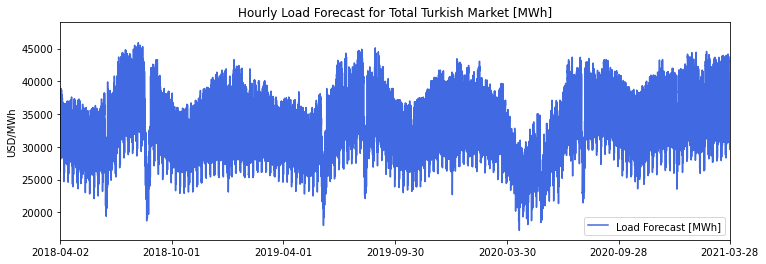

In [8]:
fig, ax = plt.subplots(figsize=figsize)
plt.plot(load_df.loc['2018-04-02':], color='royalblue', label='Load Forecast [MWh]')
plt.ylabel("USD/MWh")
plt.title("Hourly Load Forecast for Total Turkish Market [MWh]")
plt.xlim(pd.Timestamp('2018-04-02'), pd.Timestamp('2021-03-28'))
plt.ylim(top=49000)
plt.xticks(list(pd.date_range('2018-04-02', '2021-03-28', freq='W-MON')[::26]) + [pd.Timestamp('2021-03-28')])
plt.legend(loc='lower right')
plt.savefig('./plots/load.jpg')
plt.show()

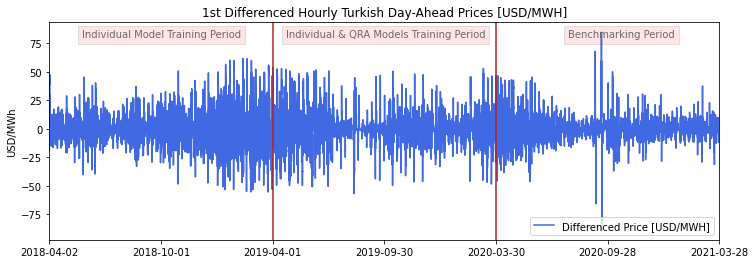

In [9]:
plt_df =  get_hourly_df(price_df, 'Price_MWh') \
.groupby(level=0, axis=0) \
.apply(lambda hour: hour.diff(1)) \
.reset_index() \
.rename(columns={'level_1': 'date', 'Price_MWh': 'Day-Ahead Price in USD/MWh'}) \
.sort_values(by='date') \
.set_index('date')[['Day-Ahead Price in USD/MWh']]\
.loc['2018-04-02':]

fig, ax = plt.subplots(figsize=figsize)
plt.plot(plt_df, color='royalblue', label='Differenced Price [USD/MWH]')
plt.ylabel("USD/MWh")
plt.title("1st Differenced Hourly Turkish Day-Ahead Prices [USD/MWH]")
plt.xlim(pd.Timestamp('2018-04-02'), pd.Timestamp('2021-03-28'))
plt.xticks(list(pd.date_range('2018-04-02', '2021-03-28', freq='W-MON')[::26]) + [pd.Timestamp('2021-03-28')])
plt.axvline(x=pd.Timestamp('2019-04-01'), color='firebrick')
plt.axvline(x=pd.Timestamp('2020-03-30'), color='firebrick')
plt.text(pd.Timestamp('2018-05-25'), 80, 'Individual Model Training Period', color='dimgray', bbox=dict(facecolor='red', alpha=0.1))
plt.text(pd.Timestamp('2019-04-22'), 80, 'Individual & QRA Models Training Period', color='dimgray', bbox=dict(facecolor='red', alpha=0.1))
plt.text(pd.Timestamp('2020-07-25'), 80, 'Benchmarking Period', color='dimgray', bbox=dict(facecolor='red', alpha=0.1))
plt.legend(loc='lower right')
plt.savefig('./plots/1st_diff_price.jpg')
plt.show()

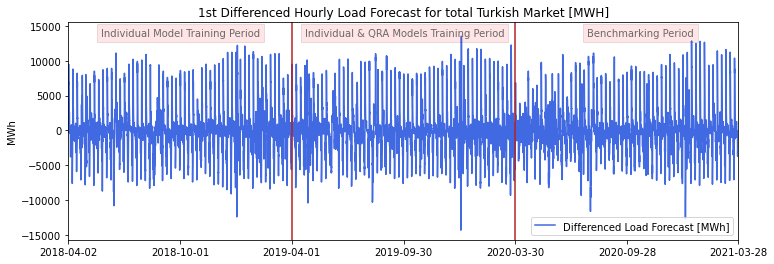

In [10]:
plt_df = get_hourly_df(load_df, 'Load_Forecast_MWh') \
.groupby(level=0, axis=0).apply(lambda hour: hour.diff(1))\
.reset_index() \
.rename(columns={'level_1': 'date', 'Load_Forecast_MWh': 'Load Forecast [MWh]'}) \
.sort_values(by='date') \
.set_index('date')[['Load Forecast [MWh]']]\
.loc['2018-04-02':]

fig, ax = plt.subplots(figsize=figsize)
plt.plot(plt_df, color='royalblue', label='Differenced Load Forecast [MWh]')
plt.ylabel("MWh")
plt.title("1st Differenced Hourly Load Forecast for total Turkish Market [MWH]")
plt.xlim(pd.Timestamp('2018-04-02'), pd.Timestamp('2021-03-28'))
plt.ylim(top=15500)
plt.xticks(list(pd.date_range('2018-04-02', '2021-03-28', freq='W-MON')[::26]) + [pd.Timestamp('2021-03-28')])
plt.axvline(x=pd.Timestamp('2019-04-01'), color='firebrick')
plt.axvline(x=pd.Timestamp('2020-03-30'), color='firebrick')
plt.text(pd.Timestamp('2018-05-25'), 13500, 'Individual Model Training Period', color='dimgray', bbox=dict(facecolor='red', alpha=0.1))
plt.text(pd.Timestamp('2019-04-22'), 13500, 'Individual & QRA Models Training Period', color='dimgray', bbox=dict(facecolor='red', alpha=0.1))
plt.text(pd.Timestamp('2020-07-25'), 13500, 'Benchmarking Period', color='dimgray', bbox=dict(facecolor='red', alpha=0.1))
plt.legend(loc='lower right')
plt.savefig('./plots/1st_diff_load.jpg')
plt.show()

## Get Prediction Intervals and combinations
This section grabs the distributional forecast of each model, combines them by utilizing various methods to get a lower and a upper bound following Gaba et al. (2017);
- Mean; simple average of lower and upper bounds of each model included.
- Median; median value of lower and upper bounds of each model included.
- Envelope; minimum of lower bounds and maximum of upper bounds.
- Interior trimming; excludes upper $\beta$ percent of the lower bounds and lower $\beta$ percent of upper bounds and takes a simple average. (Wider than simple average given $1>\beta>0$)
- Exterior trimming; excludes lower $\beta$ percent of the lower bounds and upper $\beta$ percent of upper bounds and takes a simple average. (Narrower than simple average given $1>\beta>0$)

In [11]:
PI_simple_combinations_df = PI_combinations(
        models=[
            PI_ARX_1_2_7.PI_historical,
            PI_ARX_1_2_7.PI_distributional,
            PI_ARX_1_2_7.PI_bootstrap,
            PI_ARX_to_7.PI_historical,
            PI_ARX_to_7.PI_distributional,
            PI_ARX_to_7.PI_bootstrap,
            PI_ARX_to_7_w_lasso_aic.PI_historical,
            PI_ARX_to_7_w_lasso_aic.PI_distributional,
            PI_ARX_to_7_w_lasso_aic.PI_bootstrap,
            PI_TARX_1_2_7.PI_historical,
            PI_TARX_1_2_7.PI_distributional,
            PI_TARX_1_2_7.PI_bootstrap,
            PI_TARX_to_7.PI_historical,
            PI_TARX_to_7.PI_distributional,
            PI_TARX_to_7.PI_bootstrap,
            PI_TARX_to_7_w_lasso_aic.PI_historical,
            PI_TARX_to_7_w_lasso_aic.PI_distributional,
            PI_TARX_to_7_w_lasso_aic.PI_bootstrap,
            PI_mARX_1_2_7.PI_historical,
            PI_mARX_1_2_7.PI_distributional,
            PI_mARX_1_2_7.PI_bootstrap,
            PI_mARX_to_7.PI_historical,
            PI_mARX_to_7.PI_distributional,
            PI_mARX_to_7.PI_bootstrap,
            PI_mARX_to_7_w_lasso_aic.PI_historical,
            PI_mARX_to_7_w_lasso_aic.PI_distributional,
            PI_mARX_to_7_w_lasso_aic.PI_bootstrap,
        ],
        PI = [0.5, 0.9],
        beta = 0.4 # for trimming
    )

In [12]:
# Calculate IC based combination
weights_dict = {x: eval(x + '_dist_df').model_aic for x in model_names}
weights_df = pd.concat(weights_dict.values(), axis=1, keys=weights_dict.keys()) \
.dropna() \
.apply(lambda x: x.apply(lambda y: y - min(x)), axis=1) \
.apply(lambda x: x.apply(lambda y: np.exp((-1/2)*y) / sum(np.exp((-1/2)*x))), axis=1)

get_IC_based_combination = lambda PI_type: pd.concat(
    [eval('PI_'+ x)[PI_type] for x in model_names],
    axis=1,
    keys=model_names
) \
.groupby(axis=1, level=1) \
.apply(lambda g: g.dropna().multiply(weights_df.values).sum(axis=1))

PI_IC_combinations_df = pd.concat([
    get_IC_based_combination('PI_historical'),
    get_IC_based_combination('PI_distributional'),
    get_IC_based_combination('PI_bootstrap')
    ],
    axis=1,
    keys=['PI_historical', 'PI_distributional', 'PI_bootstrap']
)

# Reliability

### Unconditional and Conditional Coverage
Unconditional coverage likelihood ratio (i.e. Kupiec's proportion of failures) test and Conditional Coverage likelihood ratio test (Nowotarski & Weron, 2018; Christoffersen, 1998)

In [13]:
UC_pct_dict = {}
for iter_key \
    in itertools.product(
    model_names,
    ['PI_historical', 'PI_distributional', 'PI_bootstrap'],
    [0.5, 0.9]
):
    UC_pct_dict.update(
        {
            iter_key:
            get_coverage_indicators(
                eval('PI_'+iter_key[0])[iter_key[1]],
                price_df,
                iter_key[2]
            ).mean()
        }
    )

In [14]:
UC_table_raw = pd.concat(UC_pct_dict.values(), axis=1, keys=UC_pct_dict.keys()) \
.stack().droplevel(0,0) \
.groupby(level=0, axis=1).apply(
    lambda x: x.droplevel(0,1)[ # re-order the columns
        ['PI_historical', 'PI_distributional', 'PI_bootstrap']
    ]
)

In [15]:
UC_table_raw.columns = list(map(add,
    [
        x.replace('_1_2_7', '') \
         .replace('_to_7', '(7)') \
         .replace('_w_lasso_aic', '$_{lasso}$')
         for x in UC_table_raw.columns.get_level_values(0)
    ],
    [
        x.replace('PI_bootstrap', '-B') \
        .replace('PI_historical', '-H') \
        .replace('PI_distributional', '-G')
        for x in UC_table_raw.columns.get_level_values(1)
    ]
))

In [16]:
wrapper_get_UC = lambda df,col_name: pd.DataFrame.from_dict({
    0.5: get_coverage_indicators(df, price_df, 0.5).mean().values[0],
    0.9: get_coverage_indicators(df, price_df, 0.9).mean().values[0]
    },
    orient='index',
).rename(columns={0: col_name})

In [17]:
UC_table = pd.concat(
    [
        wrapper_get_UC(PI_Naive, 'Naive-H'),
        wrapper_get_UC(PI_AutoAR, 'AutoAR-H'),
        UC_table_raw,
        wrapper_get_UC(PI_QRA, 'QRA'),
        wrapper_get_UC(PI_QRA_1_2_7, 'QRA(1)'),
        wrapper_get_UC(PI_QRA_to_7, 'QRA(7)'),
        wrapper_get_UC(PI_QRA_to_7_w_lasso, 'QRA(7)$_{lasso}$'),
        wrapper_get_UC(PI_simple_combinations_df.Mean, 'PI-Mean'),
        wrapper_get_UC(PI_simple_combinations_df.Median, 'PI-Median'),
        wrapper_get_UC(PI_simple_combinations_df.Envelope, 'PI-Envelope'),
        wrapper_get_UC(PI_simple_combinations_df.IntTrim, 'PI-IntTrim'),
        wrapper_get_UC(PI_simple_combinations_df.ExtTrim, 'PI-ExtTrim'),
        wrapper_get_UC(PI_IC_combinations_df.PI_historical, 'PI-IC Combine-H'),
        wrapper_get_UC(PI_IC_combinations_df.PI_distributional, 'PI-IC Combine-G'),
        wrapper_get_UC(PI_IC_combinations_df.PI_bootstrap, 'PI-IC Combine-B'),
    ],
    axis=1
).T \
.multiply(100) \
.assign(
    error_50=lambda df: df[0.5].apply(lambda x: x - 50),
    error_90=lambda df: df[0.9].apply(lambda x: x - 90)
).round(2)

In [ ]:
# Check the article for full table
UC_table.loc[lambda df: (df.error_50.abs() < 5) & (df.error_90.abs()<5)] \
.apply(lambda col: col.apply(lambda x: str(x)+'%')) \
[[0.5, 'error_50', 0.9, 'error_90']] \
.to_latex('./output/UC_table_reduced.tex')

In [ ]:
UC_table.apply(lambda col: col.apply(lambda x: str(x)+'%')) \
[[0.5, 'error_50', 0.9, 'error_90']] \
.to_latex('./output/UC_table.tex')

### Unconditional and Conditional Coverage Plots

In [20]:
title_dict={
    'ARX_1_2_7': 'ARX',
    'ARX_to_7': 'ARX(7)',
    'ARX_to_7_w_lasso_aic': 'ARX(7)$_{lasso}$',
    'TARX_1_2_7': 'TARX',
    'TARX_to_7': 'TARX(7)',
    'TARX_to_7_w_lasso_aic': 'TARX(7)$_{lasso}$',
    'mARX_1_2_7': 'mARX',
    'mARX_to_7': 'mARX(7)',
    'mARX_to_7_w_lasso_aic': 'mARX(7)$_{lasso}$',
}
sim_dict = {
    'historical':'H', 'distributional':'G', 'bootstrap':'B'
}

In [21]:
%%capture
lag = 1
for cov_type in ['UC', 'CC']:
    for model, sim in itertools.product(model_names, ['historical', 'distributional', 'bootstrap']):
        locals()[f'fig_{model}_{sim}_UC'] = plot_coverage(
            eval(f'PI_{model}')[f'PI_{sim}'],
            price_df,
            title=title_dict[model] + '-' + sim_dict[sim],
            lag=lag,
            cov_type=cov_type,
            figsize=(5,3),
            savefig=f'./plots/{cov_type}_{model}_{sim}'
        )

    plot_coverage(PI_Naive, price_df, title='Naive-H', lag=lag, cov_type=cov_type, figsize=(5,3), savefig=f'./plots/{cov_type}_Naive')
    plot_coverage(PI_AutoAR, price_df, title='AutoAR-H', lag=lag, cov_type=cov_type, figsize=(5,3), savefig=f'./plots/{cov_type}_AutoAR')
    plot_coverage(PI_QRA, price_df, title='QRA', lag=lag, cov_type=cov_type, figsize=(5,3), savefig=f'./plots/{cov_type}_QRA')
    plot_coverage(PI_QRA_1_2_7, price_df, title='QRA(1)', lag=lag, cov_type=cov_type, figsize=(5,3), savefig=f'./plots/{cov_type}_QRA(1)')
    plot_coverage(PI_QRA_to_7, price_df, title='QRA(7)', lag=lag, cov_type=cov_type, figsize=(5,3), savefig=f'./plots/{cov_type}_QRA(7)')
    plot_coverage(PI_QRA_to_7_w_lasso, price_df, title='QRA(7)$_{lasso}$', lag=lag, cov_type=cov_type, figsize=(5,3), savefig=f'./plots/{cov_type}_QRA(7)_w_lasso')
    plot_coverage(PI_simple_combinations_df.Mean, price_df, title='Mean', lag=lag, cov_type=cov_type, figsize=(5,3), savefig=f'./plots/{cov_type}_Mean')
    plot_coverage(PI_simple_combinations_df.Median, price_df, title='Median', lag=lag, cov_type=cov_type, figsize=(5,3), savefig=f'./plots/{cov_type}_Median')
    plot_coverage(PI_simple_combinations_df.ExtTrim, price_df, title='ExtTrim', lag=lag, cov_type=cov_type, figsize=(5,3), savefig=f'./plots/{cov_type}_ExtTrim')
    plot_coverage(PI_IC_combinations_df.PI_historical, price_df, title='IC Combine-H', lag=lag, cov_type=cov_type, figsize=(5,3), savefig=f'./plots/{cov_type}_IC_Combine_historical')
    plot_coverage(PI_IC_combinations_df.PI_distributional, price_df, title='IC Combine-G', lag=lag, cov_type=cov_type, figsize=(5,3), savefig=f'./plots/{cov_type}_IC_Combine_distributional')
    plot_coverage(PI_IC_combinations_df.PI_bootstrap, price_df, title='IC Combine-B', lag=lag, cov_type=cov_type, figsize=(5,3), savefig=f'./plots/{cov_type}_IC_Combine_bootstrap')

In [22]:
%%capture
# exception for Envelope and IntTrim
for m in ['Envelope', 'IntTrim']:
    percentile_df = PI_simple_combinations_df.Envelope
    for PI_width in [0.5, 0.9]:
        hourly_cov_ind_df_90 = get_coverage_indicators(percentile_df,price_df,PI_width)
        # Unconditional Coverage Likelihood-Ration Scores
        locals()[f'df_{int(PI_width*100)}'] = hourly_cov_ind_df.groupby(level=0).apply(
            lambda hour: calculate_UC_LR_score(hour, PI_width)
        ) \
        .fillna(20) \
        .rename(columns={'Cov_ind': 'UC_LR'}) \
        .UC_LR.apply(lambda x: 20 if x>20 else x).reset_index()
    fig, ax = plt.subplots(figsize=(5,3))
    plt.scatter(x=df_90.index, y=df_90.UC_LR, facecolors='none', edgecolors='blue', label='90% PI', marker="^")
    plt.scatter(x=df_50.index, y=df_50.UC_LR, facecolors='none', edgecolors='red', label='50% PI')
    ax.axhline(y=stats.chi2.ppf(0.99,df=1))
    ax.axhline(y=stats.chi2.ppf(0.95,df=1), ls='--')
    plt.yticks([0, 10, 20])
    plt.xticks([0,4,8,12,16,20,24])
    plt.ylabel("$LR_{UC}$")
    plt.title(m)
    fig.savefig(f'./plots/UC_{m}')
    plt.close(fig)

# Sharpness

## Winkler Score

In [23]:
Winkler_dict = {}
for iter_key \
    in itertools.product(
    model_names,
    ['PI_historical', 'PI_distributional', 'PI_bootstrap'],
    [0.5, 0.9]
):
    Winkler_dict.update(
        {
            iter_key:
            winkler_score(
                eval('PI_'+iter_key[0])[iter_key[1]],
                price_df,
                iter_key[2]
            ).mean()
        }
    )

In [24]:
dfWinklerRaw = pd.concat(Winkler_dict.values(), axis=0, keys=Winkler_dict.keys()) \
.unstack() \
.groupby(level=0, axis=0) \
.apply(
    lambda x: x.loc[idx[:, # re-order the columns
        ['PI_historical', 'PI_distributional', 'PI_bootstrap']
    ,:]]
).droplevel(0,0).T

In [25]:
dfWinklerRaw_50 = dfWinklerRaw.xs(0.5, level=2, axis=1).copy()
dfWinklerRaw_90 = dfWinklerRaw.xs(0.9, level=2, axis=1).copy()

In [26]:
for df in ['dfWinklerRaw_50', 'dfWinklerRaw_90']:
    locals()[df].columns = list(map(add,
    [
        x.replace('_1_2_7', '') \
         .replace('_to_7', '(7)') \
         .replace('_w_lasso_aic', '$_{lasso}$')
         for x in eval(df).columns.get_level_values(0)
    ],
    [
        x.replace('PI_bootstrap', '-B') \
        .replace('PI_historical', '-H') \
        .replace('PI_distributional', '-G')
        for x in eval(df).columns.get_level_values(1)
    ],
))

In [27]:
wrapper_winkler_mean = lambda df, width, name: winkler_score(df, price_df, width).mean().to_frame(name)

In [252]:
wrapper_winkler_total = lambda pi_width, dfRaw: pd.concat([
    wrapper_winkler_mean(PI_Naive, pi_width, 'Naive-H'),
    wrapper_winkler_mean(PI_AutoAR, pi_width, 'AutoAR-H'),
    dfRaw,
    wrapper_winkler_mean(PI_QRA, pi_width, 'QRA'),
    wrapper_winkler_mean(PI_QRA_1_2_7, pi_width, 'QRA(1)'),
    wrapper_winkler_mean(PI_QRA_to_7, pi_width, 'QRA(7)'),
    wrapper_winkler_mean(PI_QRA_to_7_w_lasso, pi_width, 'QRA(7)$_{lasso}$'),
    wrapper_winkler_mean(PI_simple_combinations_df.Mean, pi_width, 'Mean'),
    wrapper_winkler_mean(PI_simple_combinations_df.Median, pi_width, 'Median'),
    wrapper_winkler_mean(PI_simple_combinations_df.Envelope, pi_width, 'Envelope'),
    wrapper_winkler_mean(PI_simple_combinations_df.IntTrim, pi_width, 'IntTrim'),
#     wrapper_winkler_mean(PI_simple_combinations_df.ExtTrim, pi_width, 'ExtTrim'),
    wrapper_winkler_mean(PI_IC_combinations_df.PI_historical, pi_width, 'IC Combine-H'),
    wrapper_winkler_mean(PI_IC_combinations_df.PI_distributional, pi_width, 'IC Combine-G'),
    wrapper_winkler_mean(PI_IC_combinations_df.PI_bootstrap, pi_width, 'IC Combine-B')
], axis=1)

In [29]:
dfWinklerMean_50 = wrapper_winkler_total(0.5, dfWinklerRaw_50)
dfWinklerMean_90 = wrapper_winkler_total(0.9, dfWinklerRaw_90)

In [30]:
wrapper_winkler_table = lambda df, width: df.T.merge(
    df.T.sort_values('Winkler_score').reset_index().reset_index()[['index','level_0']],
    left_index=True,
    right_on='index'
) \
.rename(columns={'index':'Model', 'level_0': f'order_{width}'}) \
.set_index('Model')

In [31]:
dfWinklerTable_full = pd.concat([
    wrapper_winkler_table(dfWinklerMean_50, 0.5),
    wrapper_winkler_table(dfWinklerMean_90, 0.9)
],
    axis=1,
    keys=['50% PIs', '90% PIs']
) \
.assign(order = lambda df: df['50% PIs', 'order_0.5'] + df['90% PIs', 'order_0.9'])

In [ ]:
dfWinklerTable_full.loc[
    lambda df: (df.order < 10) |
    (df.index=='Naive-H') | (df.index=='AutoAR-H') | 
    (df.index==df['50% PIs', 'PI_Width'].idxmin()) |
    (df.index==df['90% PIs', 'PI_Width'].idxmin()) |
    (df.index==df['50% PIs', 'Penalty'].idxmin()) |
    (df.index==df['90% PIs', 'Penalty'].idxmin())
] \
.drop(['order', ('50% PIs', 'order_0.5'), ('90% PIs', 'order_0.9')],1) \
.rename(columns={'PI_Width': 'PI width', 'Winkler_score': 'Winkler score'}) \
.round(2) \
.to_latex('./output/Winkler_table_reduced.tex')

In [ ]:
dfWinklerTable_full \
.drop(['order', ('50% PIs', 'order_0.5'), ('90% PIs', 'order_0.9')],1) \
.rename(columns={'PI_Width': 'PI width', 'Winkler_score': 'Winkler score'}) \
.round(2) \
.to_latex('./output/Winkler_table_full.tex')

## Diebold - Mariano test
Test whether the difference in winkler scores is significant for two competing models.

In [193]:
dictModels = {
    'Naive-H': PI_Naive,
    'AutoAR-H': PI_AutoAR,
    'ARX-H': PI_ARX_1_2_7.PI_historical,
    'ARX-G': PI_ARX_1_2_7.PI_distributional,
    'ARX-B': PI_ARX_1_2_7.PI_bootstrap,
    'ARX(7)-H': PI_ARX_to_7.PI_historical,
    'ARX(7)-G': PI_ARX_to_7.PI_distributional,
    'ARX(7)-B': PI_ARX_to_7.PI_bootstrap,
    'ARX(7)$_{lasso}$-H': PI_ARX_to_7_w_lasso_aic.PI_historical,
    'ARX(7)$_{lasso}$-G': PI_ARX_to_7_w_lasso_aic.PI_distributional,
    'ARX(7)$_{lasso}$-B': PI_ARX_to_7_w_lasso_aic.PI_bootstrap,
    'TARX-H': PI_TARX_1_2_7.PI_historical,
    'TARX-G': PI_TARX_1_2_7.PI_distributional,
    'TARX-B': PI_TARX_1_2_7.PI_bootstrap,
    'TARX(7)-H': PI_TARX_to_7.PI_historical,
    'TARX(7)-G': PI_TARX_to_7.PI_distributional,
    'TARX(7)-B': PI_TARX_to_7.PI_bootstrap,
    'TARX(7)$_{lasso}$-H': PI_TARX_to_7_w_lasso_aic.PI_historical,
    'TARX(7)$_{lasso}$-G': PI_TARX_to_7_w_lasso_aic.PI_distributional,
    'TARX(7)$_{lasso}$-B': PI_TARX_to_7_w_lasso_aic.PI_bootstrap,
    'mARX-H': PI_mARX_1_2_7.PI_historical,
    'mARX-G': PI_mARX_1_2_7.PI_distributional,
    'mARX-B': PI_mARX_1_2_7.PI_bootstrap,
    'mARX(7)-H': PI_mARX_to_7.PI_historical,
    'mARX(7)-G': PI_mARX_to_7.PI_distributional,
    'mARX(7)-B': PI_mARX_to_7.PI_bootstrap,
    'mARX(7)$_{lasso}$-H': PI_mARX_to_7_w_lasso_aic.PI_historical,
    'mARX(7)$_{lasso}$-G': PI_mARX_to_7_w_lasso_aic.PI_distributional,
    'mARX(7)$_{lasso}$-B': PI_mARX_to_7_w_lasso_aic.PI_bootstrap,
    'QRA': PI_QRA,
    'QRA(1)': PI_QRA_1_2_7,
    'QRA(7)': PI_QRA_to_7,
    'QRA(7)$_{lasso}$': PI_QRA_to_7_w_lasso,
    'Mean': PI_simple_combinations_df.Mean,
    'Median': PI_simple_combinations_df.Median,
    'Envelope': PI_simple_combinations_df.Envelope,
    'IntTrim': PI_simple_combinations_df.IntTrim,
    'ExtTrim': PI_simple_combinations_df.ExtTrim,
    'IC Combine-H': PI_IC_combinations_df.PI_historical,
    'IC Combine-G': PI_IC_combinations_df.PI_distributional,
    'IC Combine-B': PI_IC_combinations_df.PI_bootstrap
}

In [194]:
dictWinkler = {
    0.5: {m: winkler_score(dictModels[m], price_df, 0.5) for m in dictModels.keys()},
    0.9: {m: winkler_score(dictModels[m], price_df, 0.9) for m in dictModels.keys()}
}

In [195]:
alpha = 0.05
dictDMResults = {}
for model1, model2 in itertools.product(dictModels.keys(), dictModels.keys()):
    if model1 == model2: continue
    dictDMResults.update({
            (model1, model2, 0.5): DM_test(
                dictWinkler[0.5][model1]['Winkler_score'],
                dictWinkler[0.5][model2]['Winkler_score'],
                alpha=alpha
            ),
            (model1, model2, 0.9): DM_test(
                dictWinkler[0.9][model1]['Winkler_score'],
                dictWinkler[0.9][model2]['Winkler_score'],
                alpha=alpha
            )
    })

In [196]:
dfDMResults = pd.concat(dictDMResults.values(), axis=1, keys=dictDMResults.keys()).sum()

In [197]:
dfDMResults_50 = dfDMResults.loc[idx[:,:,0.5]].droplevel(2).unstack().reindex(dictModels.keys()).reindex(columns=dictModels.keys())
dfDMResults_90 = dfDMResults.loc[idx[:,:,0.9]].droplevel(2).unstack().reindex(dictModels.keys()).reindex(columns=dictModels.keys())

In [246]:
def DM_plot(df, title, savefig, figsize=(10,10)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(df, cmap ="YlGnBu", aspect='auto')
    plt.colorbar(ticks=[0, 4, 8, 12, 16, 20, 24])
    plt.title(title)
    plt.xticks(range(len(df)), df.columns, rotation=90)
    plt.yticks(range(len(df)), df.index)
    fig.savefig(savefig, bbox_inches='tight')

In [222]:
lsDMReduced_50 = dfDMResults_50.sum(axis=1).loc[lambda x: x>750].index.to_list()
lsDMReduced_90 = dfDMResults_90.sum(axis=1).loc[lambda x: x>750].index.to_list()
lsDMReduced_raw = ['Naive-H', 'AutoAR-H', 'QRA', 'QRA(1)', 'QRA(7)', 'QRA(7)$_{lasso}$'] \
+ lsDMReduced_50 + lsDMReduced_90
lsDMReduced = pd.Series(lsDMReduced_raw).drop_duplicates().to_list()

In [253]:
dfDMResults_50.fillna(' ').to_latex('./output/DMResults_50.tex')
dfDMResults_90.fillna(' ').to_latex('./output/DMResults_90.tex')

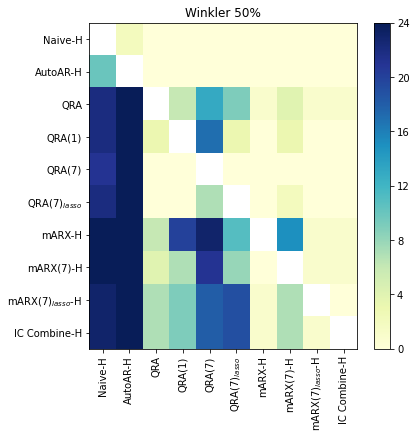

In [247]:
DM_plot(dfDMResults_50.loc[lsDMReduced, lsDMReduced], 'Winkler 50%','./plots/DMResults_reduced_50.png', (6,6))

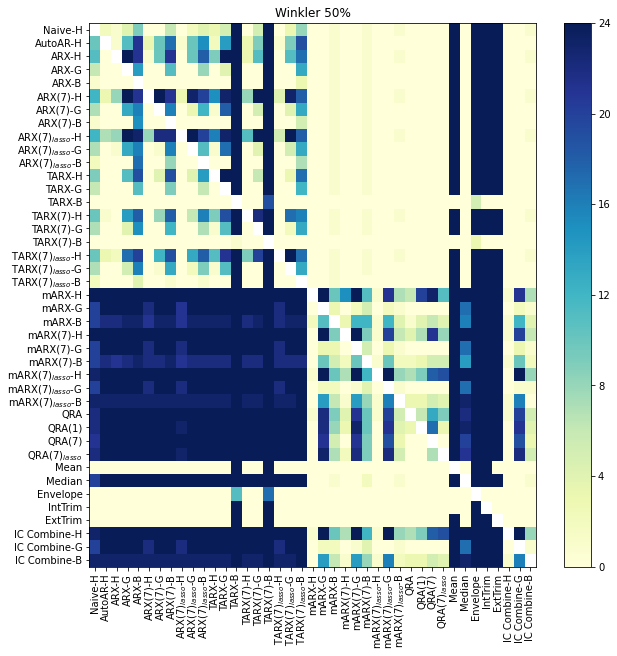

In [248]:
DM_plot(dfDMResults_50, 'Winkler 50%','./plots/DMResults_full_50.png')

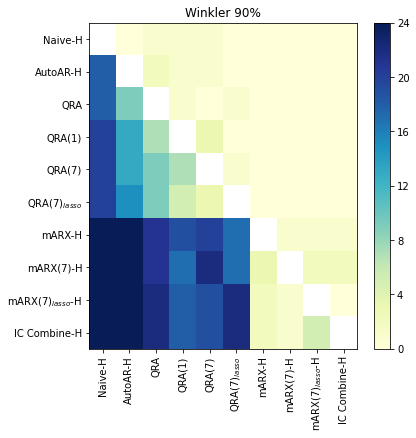

In [249]:
DM_plot(dfDMResults_90.loc[lsDMReduced, lsDMReduced], 'Winkler 90%','./plots/DMResults_reduced_90.png', (6,6))

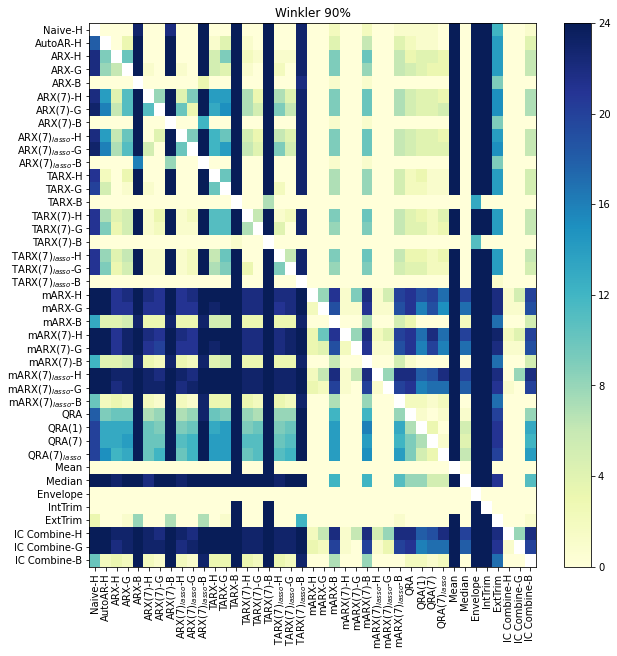

In [250]:
DM_plot(dfDMResults_90, 'Winkler 90%','./plots/DMResults_full_90.png')